In [66]:
import torch 
import torch.nn as nn
from torch.utils.data import  DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import os
from typing import Tuple, Dict, List
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
# https://medium.com/@karuneshu21/resnet-paper-walkthrough-b7f3bdba55f0
# https://arxiv.org/pdf/1512.03385.pdf
# https://medium.com/@karuneshu21/how-to-resnet-in-pytorch-9acb01f36cf5
torch.autograd.set_detect_anomaly(True)

In [112]:
class Data():
    def __init__(self) -> None:
        from torchvision.transforms import ToTensor
        import numpy as np
        from torch.utils.data import Subset
        self.train_data_full =datasets.Food101(
            root='D:\PytorchData\data',
            split="train",
            download=False,
            transform=transforms.Compose(
                [
                    transforms.Resize((224,224)),
                    transforms.ToTensor()
                ]
            )
        )
        indices = list(range(len(self.train_data_full)))
        np.random.shuffle(indices)
        split_idx = int(len(indices) * 0.001)
        self.train_data = Subset(self.train_data_full, indices[:split_idx])

        self.test_data_full=datasets.Food101(
            root='D:\PytorchData\data',
            split="test",
            download=False,
            transform=transforms.Compose(
                [
                    transforms.Resize((224,224)),
                    transforms.ToTensor()
                ]
            )
        )
        
        indices = list(range(len(self.test_data_full)))
        np.random.shuffle(indices)
        split_idx = int(len(indices) * 0.001)
        self.test_data = Subset(self.test_data_full, indices[:split_idx])


        self.classes=self.train_data_full.classes
        self.ToDataloader()
    def ToDataloader(self):
        BATCH_SIZE=32
        self.train_dataloader=DataLoader(self.train_data,batch_size=BATCH_SIZE,shuffle=True)
        self.test_dataloader=DataLoader(self.test_data,batch_size=BATCH_SIZE,shuffle=False)
        

In [113]:
def train_step(model,optimizer,loss_fn,data:Data):
    
    model.train()
    train_loss,train_acc=0,0

    for batch, (X,y) in enumerate(data.train_dataloader):
        y_logits=model(X)

        loss=loss_fn(y_logits,y)
        train_loss+=loss.item()


        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class=y_logits.argmax(dim=1)
        train_acc+=(y_pred_class==y).sum().item()/len(y_logits)

    train_loss=train_loss/len(data.train_dataloader)
    train_acc=train_acc/len(data.train_dataloader)
    return train_loss,train_acc

def test_step(model,loss_fn,data:Data):
    model.eval()
    test_loss,test_acc=0,0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(data.test_dataloader):
            y_logits=model(X)
            
            loss=loss_fn(y_logits,y)
            test_loss+=loss.item()

            y_pred_class=y_logits.argmax(dim=1)
            test_acc+=(y_pred_class==y).sum().item()/len(y_logits)

    test_loss=test_loss/len(data.test_dataloader)
    test_acc=test_acc/len(data.test_dataloader)

    return test_loss,test_acc

def Totrain(model,data:Data,optimizer,loss_fn,epochs:int):
    results={"train_loss":[],
             "train_acc" :[],
             "test_loss":[],
             "test_acc": []
             }
    
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model,optimizer,loss_fn,data)
        test_loss,test_acc=test_step(model,loss_fn,data)

                
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

In [123]:
def plot_loss_curves(results: Dict[str, List[float]]):
    import matplotlib.pyplot as plt
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.ylim([0,1775821])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    # plt.show()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [124]:
# data=CustomDataTest()

# net=ResNet(3,len(data.train_data.classes))
# net_optimizer=torch.optim.SGD(net.parameters(),lr=0.1)
# net_loss_fn=nn.CrossEntropyLoss()
# res=Totrain(net,data,net_optimizer,net_loss_fn,2)


# x=torch.randn(32,3,224,224)
# print(f"out shape {y.shape}")



RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [32, 512, 7, 7]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!


In [125]:
class SimpleResNetblock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,identity_downsample=None) -> None:
        super(SimpleResNetblock,self).__init__()

        self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=stride)
        self.bn1=nn.BatchNorm2d(out_channels)
       
        self.conv2=nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1)
        self.bn2=nn.BatchNorm2d(out_channels)
       
        self.relu=nn.ReLU()

        self.identity_downsample=identity_downsample
    
    def forward(self,x):
        identity=x
        # print(f"identity shape x{identity.shape}")
        
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)

        x=self.conv2(x)
        x=self.bn2(x)

        if self.identity_downsample != None:
            identity=self.identity_downsample(identity)
            # print(f"identity shape after {identity.shape}")
            # print(f"x shape {x.shape}")

        x+=identity
        x=self.relu(x)
        # print(f"x shape {x.shape}")

        return x


In [126]:
class ResNet18(nn.Module):
    def __init__(self,block:SimpleResNetblock,img_channels,num_classes,block_num:list) -> None:
        super(ResNet18,self).__init__()
        
        self.in_channels=64

        self.conv1=nn.Conv2d(img_channels,64,kernel_size=7,stride=2,padding=3)
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.layer2=self._make_layer(block,block_num[0],64,1)
        self.layer3=self._make_layer(block,block_num[1],128,2)
        self.layer4=self._make_layer(block,block_num[2],256,2)
        self.layer5=self._make_layer(block,block_num[3],512,2)

        

        self.avg=nn.AvgPool2d((1,1))
        self.fc=nn.Linear(512*7*7,num_classes)


    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.maxpool(x)

        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)

        
        x=self.avg(x)
        # print(f"shape after avg {x.shape}")
        x=x.reshape(x.shape[0],-1)
        # print(f"shape after reshape {x.shape}")
        x=self.fc(x)
        # print(f"output shape {x.shape}")
        
        return x
    
    def _make_layer(self,block,num_blocks,out_channels,stride):
        identity_downsample=None
        layers=[]
        if stride!=1:
            identity_downsample=nn.Sequential(
                nn.Conv2d(self.in_channels,out_channels,1,stride,padding=0),
                nn.BatchNorm2d(out_channels)
            )
        layers.append(block(self.in_channels,out_channels=out_channels,stride=stride,identity_downsample=identity_downsample))
        self.in_channels=out_channels

        for i in range(num_blocks-1):
            layers.append(block(self.in_channels,out_channels=out_channels))

        return nn.Sequential(*layers)

len train_dataloader 96
len test_dataloader 32


 25%|██▌       | 1/4 [00:07<00:22,  7.37s/it]

Epoch: 1 | train_loss: 106.1904 | train_acc: 0.0104 | test_loss: 72097756998667337728.0000 | test_acc: 0.0000


 50%|█████     | 2/4 [00:14<00:14,  7.05s/it]

Epoch: 2 | train_loss: 208.4697 | train_acc: 0.0104 | test_loss: 272849504.0000 | test_acc: 0.0000


 75%|███████▌  | 3/4 [00:21<00:06,  6.94s/it]

Epoch: 3 | train_loss: 32.8882 | train_acc: 0.0417 | test_loss: 2432330.5000 | test_acc: 0.0400


100%|██████████| 4/4 [00:27<00:00,  6.92s/it]

Epoch: 4 | train_loss: 25.0421 | train_acc: 0.0521 | test_loss: 61960.6719 | test_acc: 0.0400


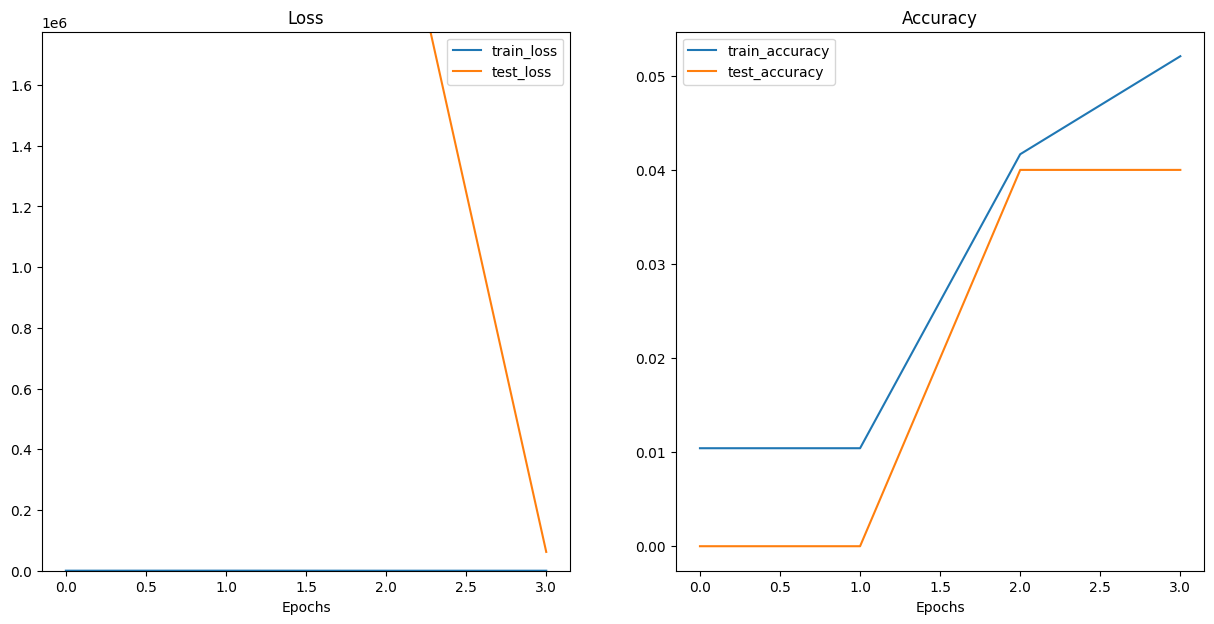

In [127]:
data=Data()
train_features_batch, train_labels_batch = next(iter(data.train_dataloader))
print(f"len train_dataloader {len(data.train_dataloader)*32}")
print(f"len test_dataloader {len(data.test_dataloader)*32}")



net30=ResNet18(SimpleResNetblock,3,len(data.classes),[3,4,6,3])
# x=torch.randn(2,3,224,224)
# print(f"in shape {x.shape}")
# y=net30(x)
# print(f"out shape {y.shape}")


net_optimizer=torch.optim.SGD(net30.parameters(),lr=0.1)
net_loss_fn=nn.CrossEntropyLoss()
resnet30_results=Totrain(net30,data,net_optimizer,net_loss_fn,5)

plot_loss_curves(resnet30_results)





In [128]:
class ResNetblock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,identity_downsample=None) -> None:
        super(ResNetblock,self).__init__()

        self.expansion=4

        self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=stride)
        self.bn1=nn.BatchNorm2d(out_channels)
       
        self.conv2=nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1)
        self.bn2=nn.BatchNorm2d(out_channels)
       
        self.conv3=nn.Conv2d(in_channels=out_channels,out_channels=out_channels*self.expansion,kernel_size=3,padding=1,stride=1)
        self.bn3=nn.BatchNorm2d(out_channels*self.expansion)
        
        
        self.relu=nn.ReLU()

        self.identity_downsample=identity_downsample
    
    def forward(self,x):
        identity=x
        # print(f"identity shape x{identity.shape}")
        
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        # print(f"after conv1 shape {x.shape}")

        x=self.conv2(x)
        x=self.bn2(x)
        # print(f"after conv2 shape {x.shape}")

        # print(f"before conv3 shape {x.shape}")
        x=self.conv3(x)
        x=self.bn3(x)
        # print(f"after conv3 shape {x.shape}")
        
        if self.identity_downsample != None:
            identity=self.identity_downsample(identity)
            # print(f"identity shape after downsample {identity.shape}")

        x+=identity
        x=self.relu(x)
        # print(f"x shape {x.shape}")

        return x


In [129]:
class ResNet50(nn.Module):
    def __init__(self,block:ResNetblock,img_channels,num_classes,block_num:list) -> None:
        super(ResNet50,self).__init__()
        
        self.in_channels=64

        self.conv1=nn.Conv2d(img_channels,64,kernel_size=7,stride=2,padding=3)
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.layer2=self._make_layer(block,block_num[0],64,1)
        self.layer3=self._make_layer(block,block_num[1],128,2)
        self.layer4=self._make_layer(block,block_num[2],256,2)
        self.layer5=self._make_layer(block,block_num[3],512,2)

        self.avg=nn.AvgPool2d((1,1))
        self.fc=nn.Linear(2048*7*7,num_classes)


    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.maxpool(x)
        
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)


        x=self.avg(x)
        # print(f"shape after avg {x.shape}")
        x=x.reshape(x.shape[0],-1)
        # print(f"shape after reshape {x.shape}")
        x=self.fc(x)
        # print(f"output shape {x.shape}")
        
        return x
    
    def _make_layer(self,block:ResNetblock,num_blocks,out_channels,stride):
        identity_downsample=None
        layers=[]

        if stride!=1 or self.in_channels!=out_channels*4:
            identity_downsample=nn.Sequential(
                nn.Conv2d(self.in_channels,out_channels*4,1,stride,padding=0),
                nn.BatchNorm2d(out_channels*4)
            )
            # print("stride test")
        
        layers.append(block(self.in_channels,out_channels=out_channels,stride=stride,identity_downsample=identity_downsample))
        self.in_channels=out_channels*4

        for i in range(num_blocks-1):
            layers.append(block(self.in_channels,out_channels=out_channels))

        return nn.Sequential(*layers)
    
    

len train_dataloader 96
len test_dataloader 32


 10%|█         | 1/10 [00:23<03:33, 23.70s/it]

Epoch: 1 | train_loss: 408.4439 | train_acc: 0.0104 | test_loss: 785015905408895728681131966464.0000 | test_acc: 0.0000


 20%|██        | 2/10 [00:48<03:15, 24.38s/it]

Epoch: 2 | train_loss: 1136.0997 | train_acc: 0.0000 | test_loss: 195614199596974080.0000 | test_acc: 0.0000


 30%|███       | 3/10 [01:11<02:44, 23.56s/it]

Epoch: 3 | train_loss: 202.1578 | train_acc: 0.0521 | test_loss: 14390734848.0000 | test_acc: 0.0000


 40%|████      | 4/10 [01:34<02:20, 23.35s/it]

Epoch: 4 | train_loss: 64.7746 | train_acc: 0.0616 | test_loss: 2800985.5000 | test_acc: 0.0000


 50%|█████     | 5/10 [01:56<01:55, 23.02s/it]

Epoch: 5 | train_loss: 52.0183 | train_acc: 0.0521 | test_loss: 1966655.8750 | test_acc: 0.0000


 60%|██████    | 6/10 [02:20<01:32, 23.19s/it]

Epoch: 6 | train_loss: 30.0974 | train_acc: 0.0521 | test_loss: 108616.0000 | test_acc: 0.0000


 70%|███████   | 7/10 [02:41<01:08, 22.67s/it]

Epoch: 7 | train_loss: 15.1892 | train_acc: 0.0312 | test_loss: 69968.2891 | test_acc: 0.0000


 80%|████████  | 8/10 [03:02<00:44, 22.16s/it]

Epoch: 8 | train_loss: 6.6717 | train_acc: 0.1231 | test_loss: 14850.8359 | test_acc: 0.0000


 90%|█████████ | 9/10 [03:26<00:22, 22.53s/it]

Epoch: 9 | train_loss: 16.9198 | train_acc: 0.1648 | test_loss: 2398.1541 | test_acc: 0.0000


100%|██████████| 10/10 [03:49<00:00, 22.92s/it]

Epoch: 10 | train_loss: 19.4959 | train_acc: 0.1042 | test_loss: 52.7650 | test_acc: 0.0000


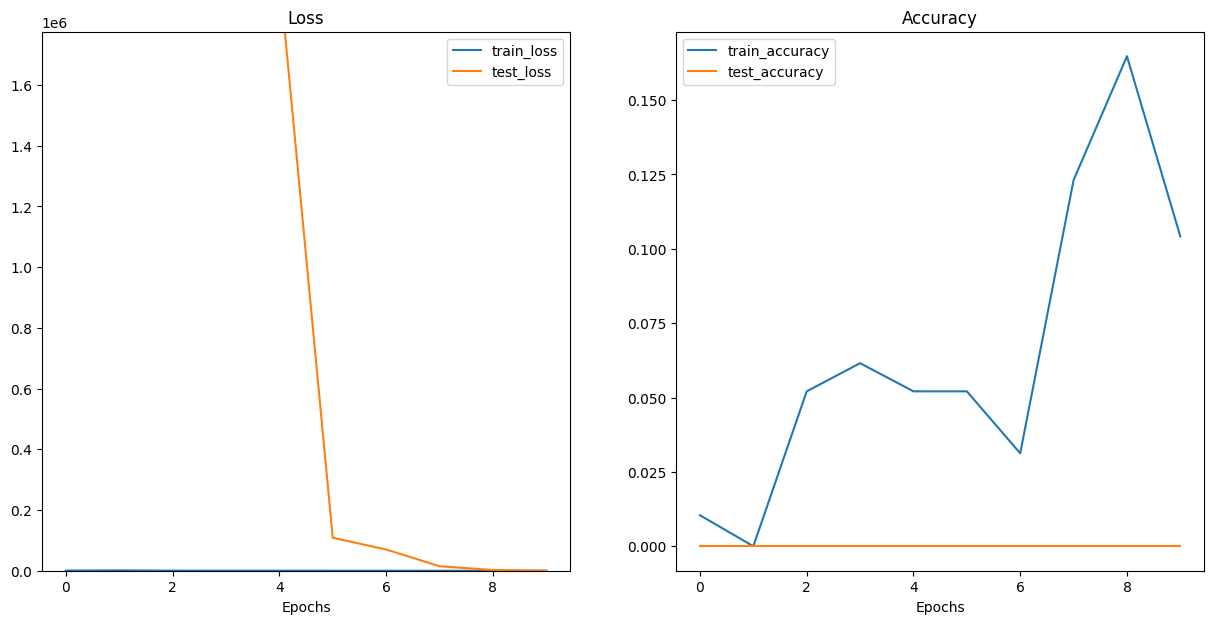

In [131]:
train_features_batch, train_labels_batch = next(iter(data.train_dataloader))
print(f"len train_dataloader {len(data.train_dataloader)*32}")
print(f"len test_dataloader {len(data.test_dataloader)*32}")

# x=torch.randn(2,3,224,224)
# net50=ResNet50(ResNetblock,3,4,[3,4,6,3])

net50=ResNet50(ResNetblock,3,len(data.classes),[3,4,6,3])

net_optimizer=torch.optim.SGD(net50.parameters(),lr=0.1)
net_loss_fn=nn.CrossEntropyLoss()
resnet50_results=Totrain(net50,data,net_optimizer,net_loss_fn,10)

plot_loss_curves(resnet50_results)

